# Group D Simple Classification

T. Lindner first notebook...

Fast streaming of data is extremely important for training ML algorithms. As such, ML libraries including `pytorch` provide useful APIs to load data during training. In this notebook, we go over an example of how to implement `pytorch` APIs for streaming the workshop data. 

We assume you know how to open the workshop `.npz` data files. If you do not know what that is, or have not yet tried [HKML Data Access & Visualization](https://github.com/WatChMaL/ExampleNotebooks/blob/master/HKML%20Data%20Access%20%26%20Visualization.ipynb) notebook, you should start from there.



There are 2 base `pytorch` modules to be implemented:
* `Dataset` ... a blob data instance, defines how data should be read from file, etc.
* `DataLoader` ... for streaming data segments from `Dataset`

In [1]:
from __future__ import print_function
import numpy as np
import os, time
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader

# Data directories: let's use e- and mu-
DATA_DIRS = ['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']



## Dataset
`Dataset` module needs implementation of two attributes: `__len__` (length of our dataset) and `__getitem__` (called to fetch an item in the ordered dataset). Below, we define `NPZDataset` which reads data from files whenever requested.

Use the HDF5 format

In [2]:
import h5py
# Open a file
f = h5py.File('/data/hkml_data/IWCDgrid/varyE/e-/IWCDgrid_varyE_e-_R0cm_20-2000MeV_100k.h5', mode='r')
# List keys
for key in f.keys():
    print('%s ... Shape %s' % (key, str(f[key].shape)))

directions ... Shape (100000, 1, 3)
energies ... Shape (100000, 1)
event_data ... Shape (100000, 88, 168, 2)
labels ... Shape (100000,)
pids ... Shape (100000, 1)
positions ... Shape (100000, 1, 3)


## DataLoader
Given a `Dataset` instance, `DataLoader` provides handy features for streaming data including randomization of samples, multi-threaded data read/process (e.g. `transform` function in `Dataset`), etc.. 

The `DataLoader` is for ML training where we typically access data by a chunk, called _batch_ (or sometimes _mini batch_). The number of samples (e.g. events) in each batch is called _batch size_ (or _mini batch size_). When preparing a batch, `DataLoader` combines (or collates) N events where N is the batch size. You need to provide a function to perform this collation.

In [3]:
class H5Dataset(Dataset):

    def __init__(self, data_dirs, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                               
        
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        for d in data_dirs:
            file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
            if limit_num_files: file_list = file_list[0:limit_num_files]
            self._files += file_list

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        return fh['event_data'][entry_index],fh['labels'][entry_index],idx

Now try plotting the data loaded from HDF5 file

300000 total events are loaded!
Entry 299994 ... label: 0.0 ... data shape: (88, 168, 2)


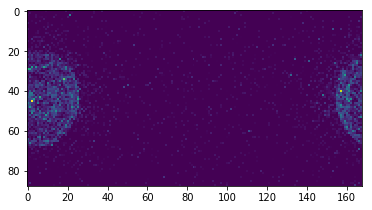

In [10]:
ENTRY = 299994
ds = H5Dataset(DATA_DIRS,flavour='100k.h5')
print(len(ds),'total events are loaded!')
# Access an index
data,label,idx = ds[ENTRY]
# Data shape
print('Entry',ENTRY,'... label:',label,'... data shape:',data.shape)
# Visualize
plt.imshow(data[:,:,0])
plt.show()

Access "5th event" and visualize